# Controlling for mixed male and female cells

For preprocessing I mainly followed this tutorial: 
(https://github.com/theislab/scanpy-tutorials/blob/master/pbmc3k.ipynb)

This pipeline can be used if the sc-RNAseq dataset contains a mix of male and female cells. It helps with exploring gene expression differences between male and female cells and provides a simple means ('regress_out') to correct for sex specific expression differences. Depending on the scientific question one would either want to correct for sex-specific differences as a potential confounder or identify and further study male and female cells within different populations in downstream analysis.

Single cell expression matrices can be loaded here. For the purpose of this tutorial I used previously published results on sexual dimorphism within the heart:
https://www.cell.com/cell-reports/pdf/S2211-1247(17)31909-5.pdf  

The processed expression file was downloaded from here:  
https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-6173/E-MTAB-6173.processed.1.zip

## 1) Loading packages + data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
import scanpy.external as sce

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/output.h5ad'
pd.show_versions()

scanpy==1.4 anndata==0.6.19 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 

INSTALLED VERSIONS
------------------
commit: None
python: 3.7.0.final.0
python-bits: 64
OS: Windows
OS-release: 8.1
machine: AMD64
processor: Intel64 Family 6 Model 69 Stepping 1, GenuineIntel
byteorder: little
LC_ALL: None
LANG: None
LOCALE: None.None

pandas: 0.23.4
pytest: 3.8.0
pip: 19.0.3
setuptools: 40.2.0
Cython: 0.28.5
numpy: 1.15.4
scipy: 1.1.0
pyarrow: None
xarray: None
IPython: 6.5.0
sphinx: 1.7.9
patsy: 0.5.0
dateutil: 2.7.3
pytz: 2018.5
blosc: None
bottleneck: 1.2.1
tables: 3.4.4
numexpr: 2.6.8
feather: None
matplotlib: 2.2.3
openpyxl: 2.5.6
xlrd: 1.1.0
xlwt: 1.3.0
xlsxwriter: 1.1.0
lxml: 4.2.5
bs4: 4.6.3
html5lib: 1.0.1
sqlalchemy: 1.2.11
pymysql: None
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None


In [2]:
sc.settings.set_figure_params(dpi=80)

In [3]:
# read in data- depends which format it is in

# this is for 10x_mtx files
#adata = sc.read_10x_mtx(
#    './data/...', var_names='gene_symbols', cache=True)

#this is for .csv files
adata = sc.read_text('./E-MTAB-6173.processed.1/full_count_matrix.txt', delimiter=None, first_column_names=None, dtype='float32')


In [4]:
adata

AnnData object with n_obs × n_vars = 27998 × 10562 

In [5]:
adata = adata.transpose() # depending how your matrix looks like this may or may not need to be done
adata.write(results_file)

In [6]:
adata.var_names_make_unique()

## 2) Preprocessing

In [7]:
adata = sc.read(results_file)

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# create metacolums in adata.obs for percentage mitochondrial counts and total counts/gene
mito_genes = adata.var_names.str.startswith('mt-')
# replaced the "MT" with small caps "mt" otherwise couldn't be found
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

# version for sparse matrix
#adata.obs['percent_mito'] = np.sum(
#    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
#adata.obs['n_counts'] = adata.X.sum(axis=1).A1

# version for non-sparse matrix
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)


# Filter cells that exceed 2500 counts (doublets) and have more than 5% mitochondrial counts (dead)
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

sc.pp.filter_genes(adata, min_counts=1) # drop genes that have less than one count

# normalize to 10K counts/cell and logtransform
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

# save results
adata.write(results_file)
adata

filtered out 8 cells that have less than 200 genes expressed
filtered out 10899 genes that are detected in less than 3 cells
filtered out 103 genes that are detected in less than 1 counts


AnnData object with n_obs × n_vars = 6599 × 16996 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'n_counts'

## 3) Generate some metadata indicating male/female cells

I will used the gene Xist for identifying female cells. Xist is a long non coding RNA that is expressed in all cells to silence one of the two X chromosomes in female cells.  
More information on Xist: https://en.wikipedia.org/wiki/XIST

**Plot the Xist expression first with a histogram**

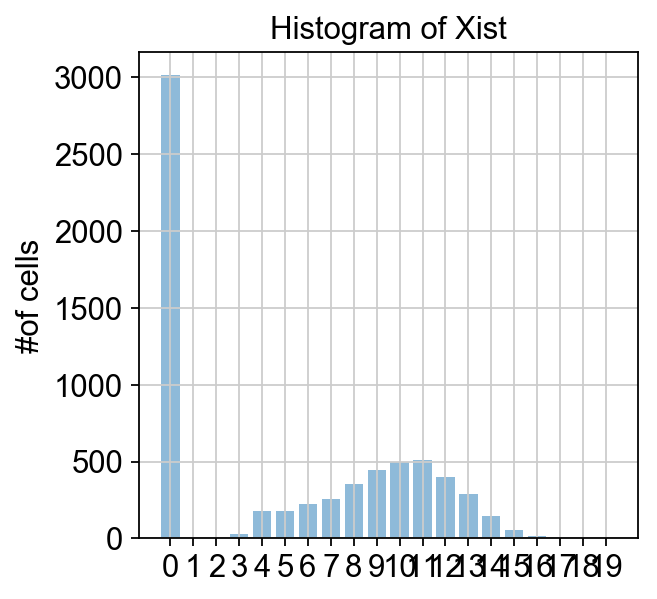

In [8]:
# if your data is in integer form you can easily plot a histogram of Xist counts with this function
# plt.hist(adata[: , 'Xist'].X, bins=30) # plot the expression of female cells

# if your data is in float form you first have to bin the counts before you can plot as a histogram.
bins = 20
hist, bin_edges = np.histogram((adata[: , 'Xist'].X), bins=bins)

y_pos = np.arange(len(bin_edges[1:]))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos)
plt.ylabel('#of cells')
plt.title('Histogram of Xist')
 
plt.show()

In [9]:
adata.obs['Female'] = adata[: , 'Xist'].X > 0 # make a column in adata.obs to identify female cells
adata.obs['rXist'] = adata[: , 'Xist'].X + 0.01 # make a column in adata.obs that stores the actual values of Xist, add 0.01 to get rid of "0" for downstream processin 
adata.obs['Female_cat']=adata.obs['Female'].astype('category', copy=True) # make a column with category as dtype

In [10]:
print(np.sum(adata.obs['Female'])/len(adata.obs['Female'])) # percent of female cells

0.5432641309289287


In [11]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 6599 × 16996 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Female', 'rXist', 'Female_cat'
    var: 'n_cells', 'n_counts'

## 4)  Explore expression differences in male vs female cells

ranking genes


C:\Users\Eva\Anaconda3\envs\scRNA\lib\site-packages\scanpy\tools\_rank_genes_groups.py:192: RuntimeWarning: overflow encountered in int_scalars
  denominator_dof = (np.square(vars[igroup]) / (np.square(ns_group)*(ns_group-1))) + (
C:\Users\Eva\Anaconda3\envs\scRNA\lib\site-packages\scanpy\tools\_rank_genes_groups.py:193: RuntimeWarning: overflow encountered in int_scalars
  (np.square(var_rest) / (np.square(ns_rest) * (ns_rest - 1))))


    finished (0:00:02.09) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


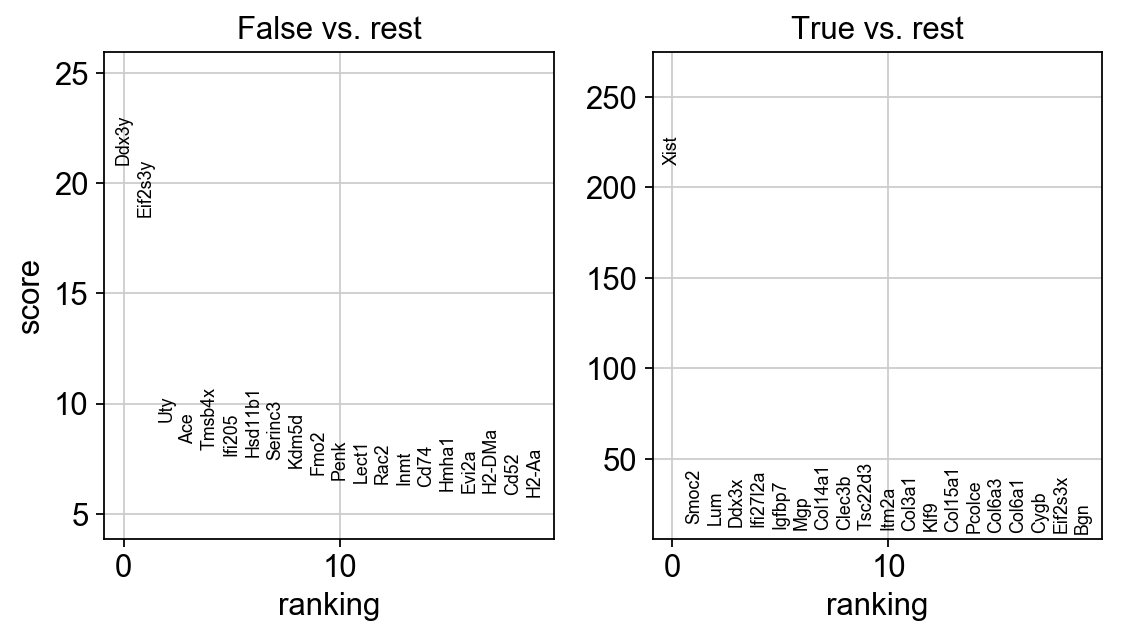

In [12]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'Female_cat')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

If you see a difference in genes that are not sex-relate (expressed on Y-chromosome or Xist) then proceed. If not then no need to correct.

## 5) Regress out differences using Xist

This proceedure fits a linear model (GLM function from statsmodels.api) for each gene vs Xist and saves the resulting residuals. If there is no correlation the variability of that gene will be preserved in the residuals. In contrary if the variability in the gene can be explained by Xist then resulting residuals will be small and the effect of that genes is therefore "regressed out".

https://github.com/theislab/scanpy/blob/ec483681434c4d6fe8c6319259d3be010ec406f8/scanpy/preprocessing/_simple.py

In [13]:
#regresses out Xist from adata and saves a copy with the new name adata_R
adata_R = sc.pp.regress_out(adata, ['rXist'], copy=True)
adata_R.write(results_file)

regressing out ['rXist']
    finished (0:05:59.77)


Compare the gene expression between male and female cells again just to make sure that everything went correctly

ranking genes


C:\Users\Eva\Anaconda3\envs\scRNA\lib\site-packages\scanpy\tools\_rank_genes_groups.py:192: RuntimeWarning: overflow encountered in int_scalars
  denominator_dof = (np.square(vars[igroup]) / (np.square(ns_group)*(ns_group-1))) + (
C:\Users\Eva\Anaconda3\envs\scRNA\lib\site-packages\scanpy\tools\_rank_genes_groups.py:193: RuntimeWarning: overflow encountered in int_scalars
  (np.square(var_rest) / (np.square(ns_rest) * (ns_rest - 1))))


    finished (0:00:02.81) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


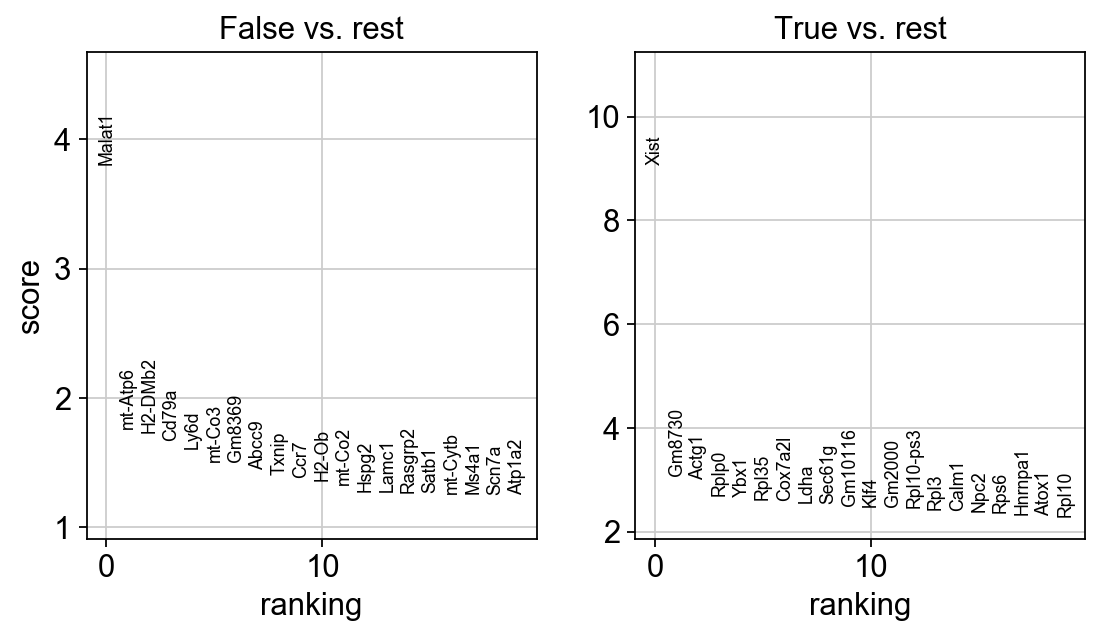

In [14]:
adata_R = sc.read(results_file)
sc.tl.rank_genes_groups(adata_R, 'Female_cat')
sc.pl.rank_genes_groups(adata_R, n_genes=20, sharey=False)

ranking genes


C:\Users\Eva\Anaconda3\envs\scRNA\lib\site-packages\scanpy\tools\_rank_genes_groups.py:192: RuntimeWarning: overflow encountered in int_scalars
  denominator_dof = (np.square(vars[igroup]) / (np.square(ns_group)*(ns_group-1))) + (
C:\Users\Eva\Anaconda3\envs\scRNA\lib\site-packages\scanpy\tools\_rank_genes_groups.py:193: RuntimeWarning: overflow encountered in int_scalars
  (np.square(var_rest) / (np.square(ns_rest) * (ns_rest - 1))))


    finished (0:00:03.12) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


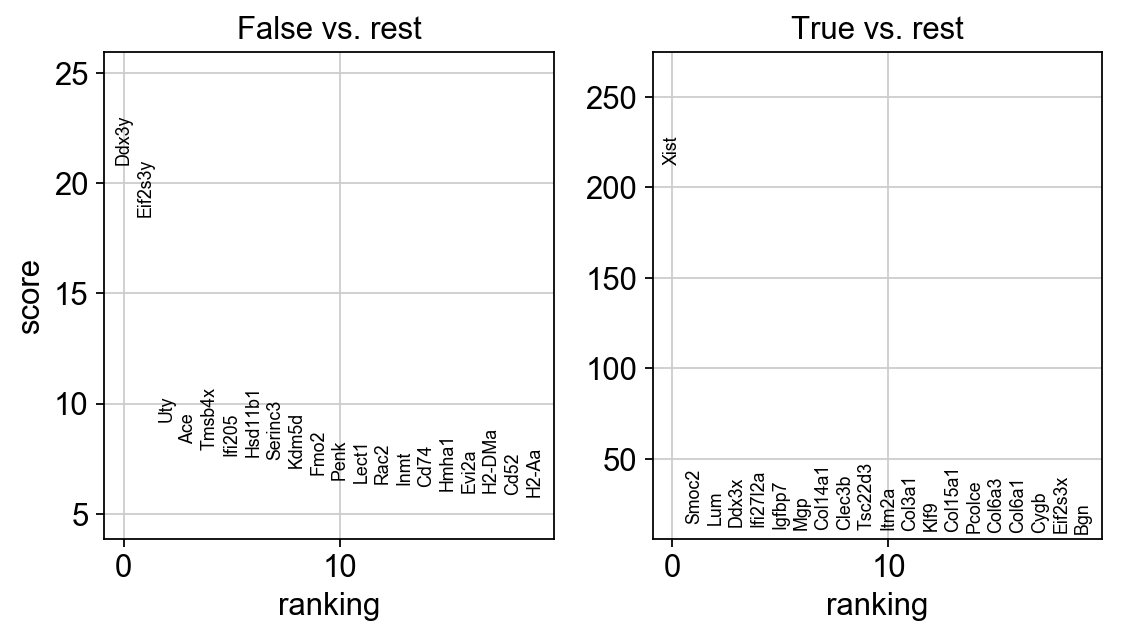

In [15]:
sc.tl.rank_genes_groups(adata, 'Female_cat')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

## 6) Further downstream processing to visualize if Xist regression made a difference

(not really necessary) Plotting the processed datasets in low dimensional space and allows to visually explore gene expression in the corrected and uncorrected expression matrix. 

In [16]:
# save the uncorrected expression file
adata.raw = adata
adata_R.raw = adata_R

#identify highly variable genes and select those for downstream processing
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]
# Regress out effects of counts and percent mitochondria - this is optional
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'], copy=False)
#scale to unit variance
sc.pp.scale(adata, max_value=10)
adata.write(results_file)

sc.pp.highly_variable_genes(adata_R, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_R = adata_R[:, adata_R.var['highly_variable']]
# Regress out effects of counts and percent mitochondria - this is optional
sc.pp.regress_out(adata_R, ['n_counts', 'percent_mito'], copy=False)
#scale to unit variance
sc.pp.scale(adata_R, max_value=10)
adata_R.write(results_file)

#show the adata file
print('-----these are the dimensions of the Xists_corrected adata_R file-----')
print(adata_R)

#show the adata file
print('-----these are the dimensions of the uncorrected adata file-----')
print(adata)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['n_counts', 'percent_mito']
    finished (0:00:33.50)


C:\Users\Eva\Anaconda3\envs\scRNA\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:103: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['n_counts', 'percent_mito']
    finished (0:00:24.55)
-----these are the dimensions of the Xists_corrected adata_R file-----
AnnData object with n_obs × n_vars = 6599 × 1489 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Female', 'rXist', 'Female_cat'
    var: 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'rank_genes_groups'
-----these are the dimensions of the uncorrected adata file-----
AnnData object with n_obs × n_vars = 6599 × 1696 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Female', 'rXist', 'Female_cat'
    var: 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'rank_genes_groups'


### Dimensionality reduction (using PCA and UMAP) to visualize differences

computing neighbors
    using 'X_pca' with n_pcs = 40


C:\Users\Eva\Anaconda3\envs\scRNA\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:17.60) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:35.94) --> added
    'X_umap', UMAP coordinates (adata.obsm)


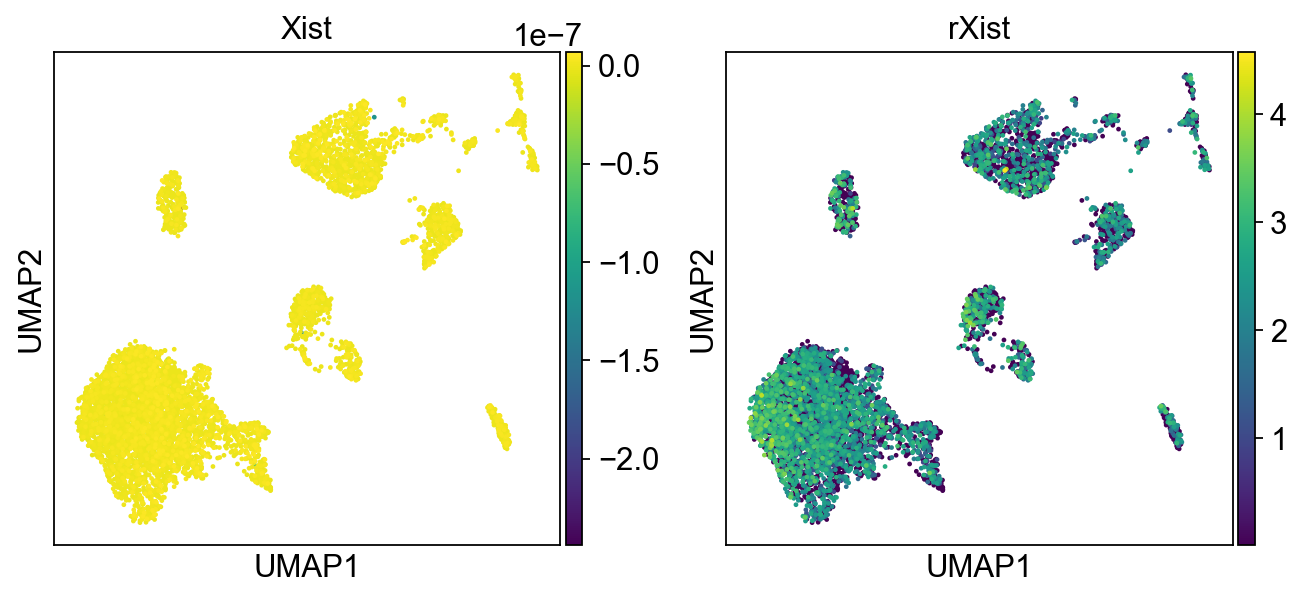

In [17]:
# run PCA and UMAP on adata_R (female corrected) file

sc.tl.pca(adata_R, svd_solver='arpack')
adata_R.write(results_file)

adata_R = sc.read(results_file)
sc.pp.neighbors(adata_R, n_neighbors=25, n_pcs=40)
sc.tl.umap(adata_R)

sc.pl.umap(adata_R, color=['Xist', 'rXist'])

#### Xist gene expression after regression (left) versus original Xist expression values stored in adata.obs['rXist']

computing neighbors
    using 'X_pca' with n_pcs = 40


C:\Users\Eva\Anaconda3\envs\scRNA\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:05.88) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:25.34) --> added
    'X_umap', UMAP coordinates (adata.obsm)


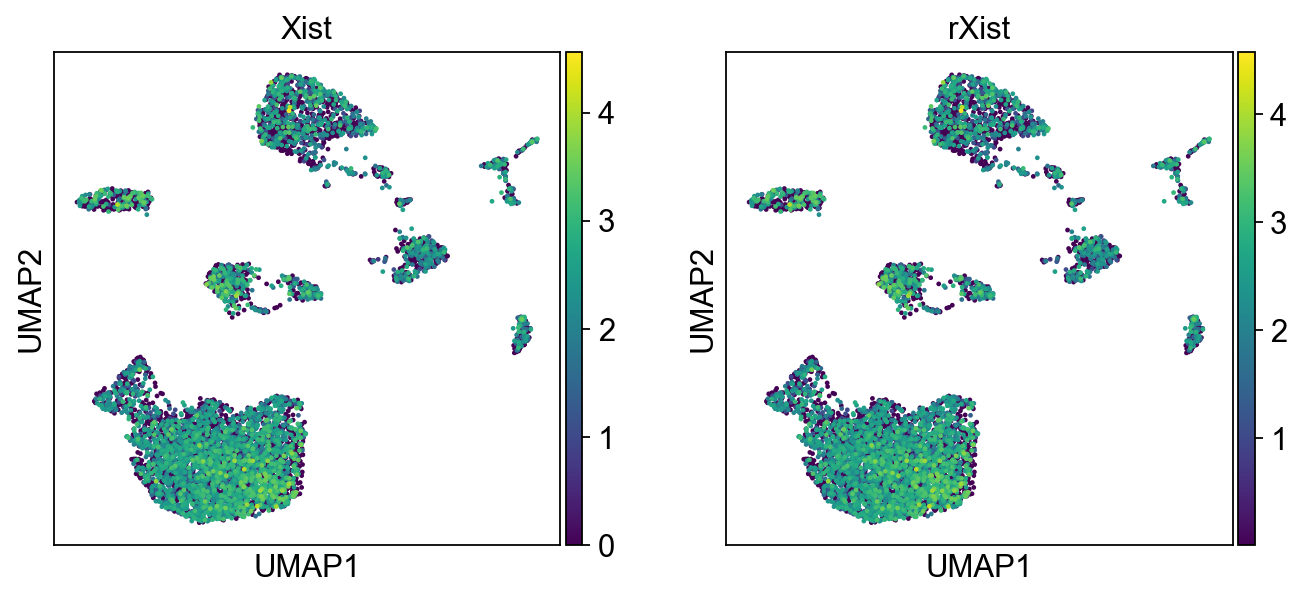

In [18]:
# run PCA and UMAP on adata file
sc.tl.pca(adata, svd_solver='arpack')
adata.write(results_file)

adata = sc.read(results_file)
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=40)
sc.tl.umap(adata)

sc.pl.umap(adata, color=['Xist', 'rXist'])

#### as a control when comparing the levels of Xist to the values that are orginally stored there is not difference in the non regressed file adata

In [19]:
# save both files for easy retrieval later on
adata_R.write(filename='female_regressed.h5ad')
adata.write(filename='female_NOTregressed.h5ad')

#### Coming soon:
Other ways of correcting for female cell...

Correct via Batch balanced KNN
https://github.com/Teichlab/bbknn#batch-balanced-knn

Matching mutual nearest neighbors (MNN)
https://github.com/chriscainx/mnnpy